In [ ]:
from google.colab import drive
drive.mount('/content/drive')


MessageError: Error: credential propagation was unsuccessful

In [ ]:
import os

# Specify the folder path (Change this to your actual folder inside Drive)
folder_path = "/content/drive/MyDrive/Crema"

# Define audio file extensions
audio_extensions = (".wav")

# Count files with audio extensions
audio_files = [f for f in os.listdir(folder_path) if f.lower().endswith(audio_extensions)]

print(f"Total number of audio files: {len(audio_files)}")

Total number of audio files: 7462


# ***Installing*** ***Dependencies***

In [ ]:
!pip install torch torchaudio transformers librosa pandas numpy scikit-learn matplotlib seaborn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

# **Code for Cleaning Audio Dataset**

In [ ]:
import os
import pandas as pd
import torchaudio

# Path to dataset
DATASET_PATH = "/content/drive/MyDrive/Crema"

# Get all audio files
audio_files = [os.path.join(DATASET_PATH, f) for f in os.listdir(DATASET_PATH) if f.endswith('.wav')]

# Extract emotion labels from filenames
def extract_emotion(filename):
    return filename.split('_')[2].upper()  # Standardize emotion labels to lowercase

# Create DataFrame
metadata = pd.DataFrame({"File_Path": audio_files, "Emotion": [extract_emotion(os.path.basename(f)) for f in audio_files]})

# Remove duplicate rows
metadata = metadata.drop_duplicates()

# Check and remove corrupt/empty audio files
valid_files = []
for file_path in metadata["File_Path"]:
    try:
        waveform, _ = torchaudio.load(file_path)
        if waveform.shape[1] > 0:  # Ensure the file is not empty
            valid_files.append(file_path)
    except Exception as e:
        print(f"Skipping corrupted file: {file_path} - {e}")

# Update dataset
metadata = metadata[metadata["File_Path"].isin(valid_files)]

print(f"Final dataset size: {metadata.shape}")


Final dataset size: (7462, 2)


In [ ]:
metadata.to_csv("/content/drive/MyDrive/crema_metadata.csv", index=False)

# **Data Description & Visualization**

          Duration
count  7462.000000
mean      2.542570
std       0.505694
min       1.267937
25%       2.168813
50%       2.502500
75%       2.836187
max       5.005000


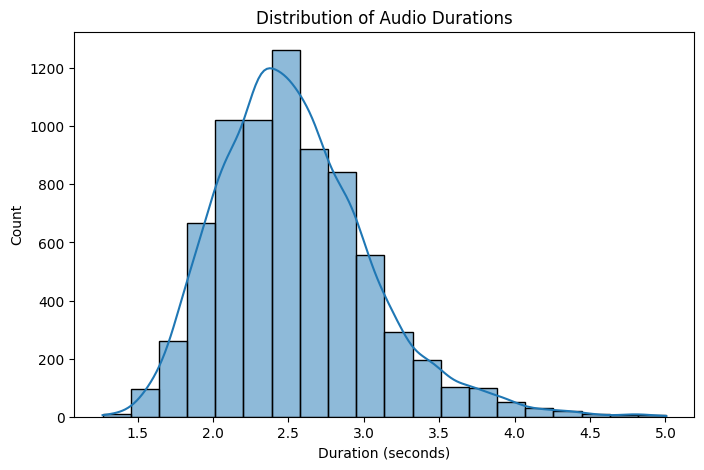

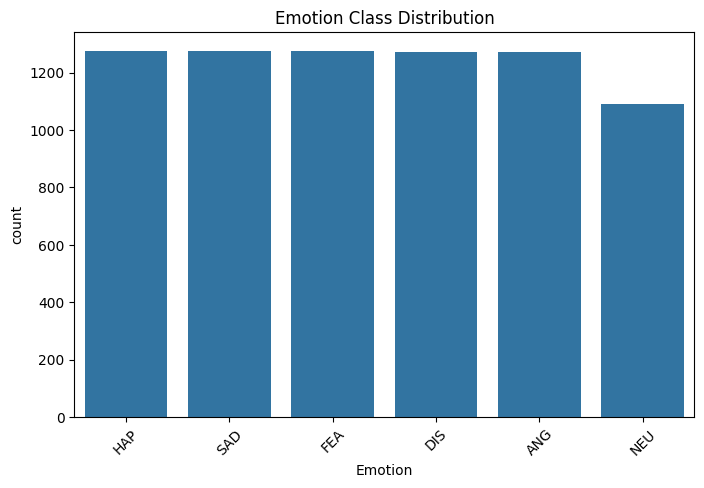

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate audio durations
durations = []
for file_path in metadata["File_Path"]:
    waveform, sample_rate = torchaudio.load(file_path)
    durations.append(waveform.shape[1] / sample_rate)  # Convert samples to seconds

# Add durations to dataset
metadata["Duration"] = durations

# Describe dataset
print(metadata.describe())

# Plot Histogram of Audio Durations
plt.figure(figsize=(8, 5))
sns.histplot(metadata["Duration"], bins=20, kde=True)
plt.title("Distribution of Audio Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.show()

# Countplot for Emotion Labels
plt.figure(figsize=(8, 5))
sns.countplot(x=metadata["Emotion"], order=metadata["Emotion"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Emotion Class Distribution")
plt.show()


# **Model-Free Evidence (Scatter Plots, Box Plots)**

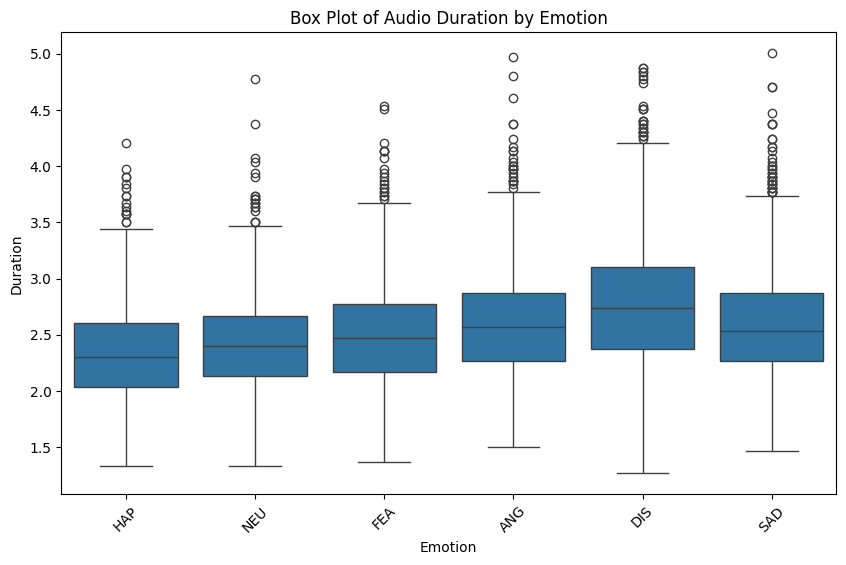

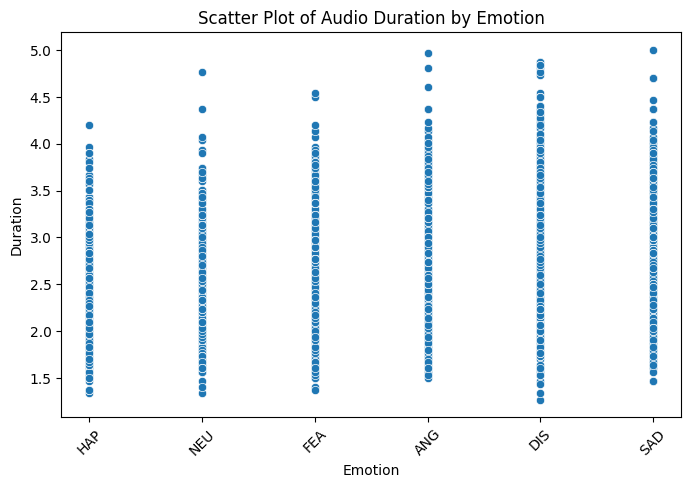

In [ ]:
# Box Plot of Audio Durations by Emotion
plt.figure(figsize=(10, 6))
sns.boxplot(x="Emotion", y="Duration", data=metadata)
plt.xticks(rotation=45)
plt.title("Box Plot of Audio Duration by Emotion")
plt.show()

# Scatter Plot of Duration vs Emotion
plt.figure(figsize=(8, 5))
sns.scatterplot(x="Emotion", y="Duration", data=metadata)
plt.xticks(rotation=45)
plt.title("Scatter Plot of Audio Duration by Emotion")
plt.show()


In [ ]:
import pandas as pd

# Define subset size (e.g., 2,000 random samples)
subset_size = 500

# Take a random sample
metadata_sample = metadata.sample(n=subset_size, random_state=42)

# Check dataset size
print("Subset Dataset Size:", metadata_sample.shape)


Subset Dataset Size: (500, 3)


# **# Feature Extraction (Constructing Model Variables) using HuBERT**

In [ ]:
from transformers import Wav2Vec2FeatureExtractor, HubertModel
import torch

# Load HuBERT
device = "cuda" if torch.cuda.is_available() else "cpu"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-base-ls960")
hubert_model = HubertModel.from_pretrained("facebook/hubert-base-ls960").to(device)

# Label Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
metadata_sample["Emotion_Label"] = le.fit_transform(metadata_sample["Emotion"])

# Extract Features
def extract_features(audio_path):
    waveform, sample_rate = torchaudio.load(audio_path)
    waveform = waveform.mean(dim=0)  # Convert to mono
    waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)

    inputs = feature_extractor(waveform.numpy(), sampling_rate=16000, return_tensors="pt", padding=True)

    with torch.no_grad():
        outputs = hubert_model(inputs.input_values.to(device)).last_hidden_state.mean(dim=1).cpu().numpy()

    return outputs.flatten()

# Apply Feature Extraction
metadata_sample["Features"] = metadata_sample["File_Path"].apply(extract_features)

# Convert to NumPy Array
X = np.stack(metadata_sample["Features"].values)
y = metadata_sample["Emotion_Label"].values

# Check Feature Shape
print(f"Feature Shape: {X.shape}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Feature Shape: (500, 768)


In [ ]:
metadata_sample.to_csv("/content/drive/MyDrive/crema_metadata.csv", index=False)